<h1><center>Reddit Sentiment Analysis - C964 Vikram Reddy</center></h1>

In [1]:
#import packages
import praw
from datetime import date, timedelta
import os
import pandas as pd
import matplotlib.pyplot as plt
from dash import Dash, dcc, html, Input, Output, dash_table, callback
import dash_bootstrap_components as dbc
from dash_bootstrap_templates import load_figure_template, template_from_url
import plotly.express as px
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from IPython.core.display_functions import display

Define Variables

In [2]:
g_client_id="hwukA0emNXXE_iaver84pg"
g_client_secret="Gly0NvAbFwi5rFmjN-UvyjfJ3uIP8g"
g_user_agent="SentimentAnalysisScraper"
g_subreddit = "Excel"
g_num_posts=25

<h2>Getting Posts and Comments from Reddit</h2>

In [3]:
def init_reddit_app():
    reddit = praw.Reddit(
        client_id=g_client_id,
        client_secret=g_client_secret,
        user_agent=g_user_agent
    )
    return reddit


def get_posts(reddit, subreddit,time_span):
    posts = []
    top_posts = reddit.subreddit(subreddit).top(time_filter=time_span, limit=g_num_posts)

    for post in top_posts:
        posts.append(post.id)
    return posts


def get_comments(reddit, posts_id):
    df_comments = pd.DataFrame(columns=['post_id', 'comment_id', 'comment_text'])
    for _id in posts_id:
        submission = reddit.submission(id=_id)
        #print(submission.title, submission.num_comments)
        submission.comments.replace_more(limit=0)

        for comment in submission.comments.list():
            try:
                df_comments.loc[len(df_comments.index)] = [comment.submission.id, comment.id, comment.body]
            except AttributeError:
                pass
    return df_comments


def get_data(subreddit,time_span):
    reddit = init_reddit_app()
    postids = get_posts(reddit, subreddit, time_span)
    df = get_comments(reddit, postids)
#   display(df)
    return df

## Score the Comments

In [45]:
def sentiment_analyser_score(df):
    analyser = SentimentIntensityAnalyzer()
    df_sentiment = pd.DataFrame(columns=["comment_id", "comp_score", "sentiment"])
    #   values = list(df.comment_text.values.flatten())
    values = list(df.comment_text.values)
    for row in values:
        score = analyser.polarity_scores(row)
        if score["compound"] > 0.5:
            sentiment = "positive"
        elif score["compound"] < -0.05:
            sentiment = "negative"
        else:
            sentiment = "neutral"
        df_sentiment.loc[len(df_sentiment.index)] = [df.comment_id.loc[len(df_sentiment.index)], score["compound"], sentiment]
        #      Add sentiment to df
    combined_df = df_sentiment.join(df.set_index("comment_id"), on="comment_id")
    #display(combined_df)

    return combined_df

def score_data(df):
    """
    """
    _df = sentiment_analyser_score(df).sort_values(by='comp_score',ascending=False)
  #  display(_df['comment_text'].head(10))         
    return _df

def get_scored_data(time):
    df = score_data(get_data(g_subreddit,time))
    return df
    

In [38]:
def display_comments(df):
    _df= sentiment_analyser_score(df).sort_values(by='comp_score',ascending=False)
    display(_df["comment_text"].head(10))
   

    
    #return _df


In [6]:
def make_plot(df):
    df = df["comp_score"].rolling(400).mean()
    plt.plot(df)
    plt.xlabel("comment no")
    plt.ylabel("Compound Sentiment Score")
    plt.title("Running mean of Compound Sentiment Score, /r/soccer")
    plt.show()

In [7]:
def make_chart(df,time):
    fig, ax = plt.subplots()
    df=df["sentiment"].value_counts().sort_index(axis=0).plot(kind='bar',color=['tab:red','tab:blue','tab:green'])
    plt.title("Sentiment in /r/" + g_subreddit + " comments from past " + time)
    ax.bar_label(ax.containers[0], label_type='edge')
    ax.set_ylabel('# of comments')
    plt.xticks(rotation=0)
    plt.show()


In [52]:
load_figure_template("superhero")

app = Dash(__name__, external_stylesheets=[dbc.themes.SUPERHERO])
dropdown = dcc.Dropdown(["day", "week", "month"], "day", clearable=False)
graph = dcc.Graph()
app.layout = html.Div([html.H4("display comments"), dropdown, graph])

@callback(Output(graph, "figure"), Input(dropdown, "value"))
def update_bar_chart(time):
       df= get_scored_data(time)
       dfs=df["sentiment"].value_counts().sort_index(axis=0)
       fig = px.bar(
              dfs, 
              x=dfs.index, y=dfs.values, 
              color=dfs.index, color_discrete_map={'positive':'green','negative':'red','neutral':'blue'},
              title=("Sentiment in /r/" + g_subreddit + " comments from past " + time)
              ).update_layout(xaxis_title = 'Sentiment')
       

       return fig



if __name__ == "__main__":
    app.run_server(debug=True)

In [54]:

def comp_chart(df_d,df_w,df_m): 
        fig, ax = plt.subplots()
        time = ['day', 'week', 'month']
        freq = [int(df_d['sentiment'].value_counts()["positive"]/len(df_d)*100),
                int(df_w['sentiment'].value_counts()["positive"]/len(df_w)*100),
                int(df_m['sentiment'].value_counts()["positive"]/len(df_m)*100)
                ]
        ax.bar(time, freq)
        ax.set_ylabel('% of positive comments')
        ax.bar_label(ax.containers[0], label_type='edge')
        ax.set_title('Percentage of Positive /r/'+ g_subreddit + ' comments')
        plt.show()

importing posts


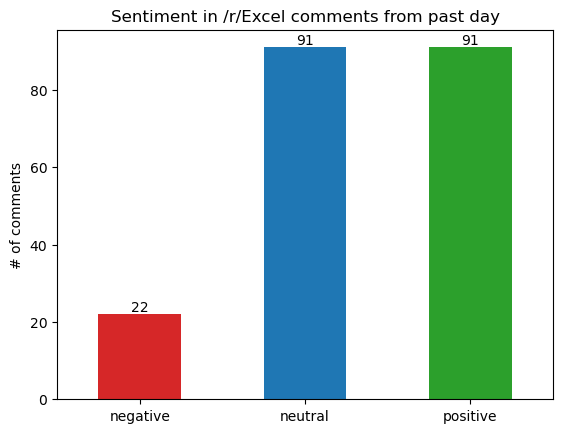

In [12]:
print("importing posts")
df_day = get_data(g_subreddit,'day')
    
    #Analyze
scores_day = score_data(df_day)
   
    #Generate Charts
plot_day = make_chart(scores_day,"day") 

## Percentage of positive comments over time

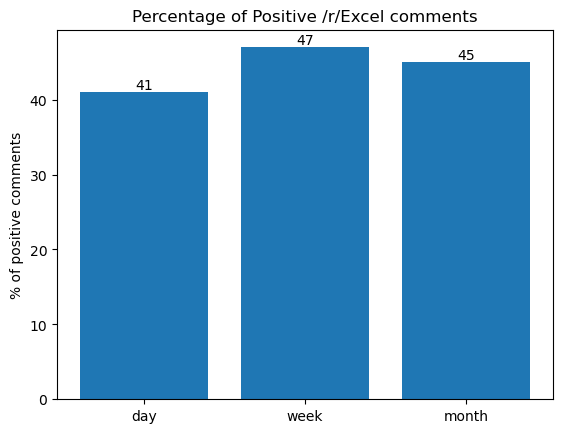

In [55]:

comp_chart(get_scored_data('day'),get_scored_data('week'),get_scored_data('month')) 